# Visión por Computador - Práctica 2 - Deep Learning en Computer Vision

#### 12 puntos   |   Fecha de entrega: 15 de Diciembre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2425.ugr.es/

### Estudiante: CARMEN AZORÍN MARTÍ

# <font color='blue'>**Ejercicio  3: Transfer Learning y fine-tuning con ResNet50 en el SPR X-Ray Age Prediction Challenge (3.5 points)**
<font color='blue'>En este ejercicio trabajaremos con el _SPR X-Ray Age Prediction Challenge_ de Kaggle (https://www.kaggle.com/competitions/spr-x-ray-age/data). Este dataset consta de $10 702$ radiografías de tórax, y el objetivo es predecir la edad de la persona a partir de la imagen de la radiografía. En esta ocasión, se emplearán $6 702$ imágenes para entrenamiento y $4 000$ para test. Las edades oscilan entre los 18 y los 89 años. Para facilitar el trabajo al alumnado se proporciona una versión procesada de los datos (con resolución $224\times224$, en lugar de $1024\times1024$, y empleando solo ejemplos para los cuales se tiene salida deseada (dado que, al tratarse de una challenge de kaggle, el conjunto de test está disponible pero sin etiquetar)). Estos datos se pueden acceder desde: https://drive.google.com/drive/folders/1hCWfTLs1w0h5kObl6NEIhEtH5VDmmCnj?usp=sharing (se debe emplear una cuenta de la UGR para acceder a dicha URL, y la información allí contenida (directorio `spr-x-ray-age`) se debe incluir en la carpeta `Colab Notebooks`).

<font color='blue'>Se debe emplear un $20\%$ de los datos de entrenamiento para validación, y el rendimiento debe ser evaluado, como mínimo, por medio de $MSE$, $MAE$ y $R^2$ _(coefficient of determination) score_. Se deben justificar las decisiones tomadas, como la elección de la función de pérdida. Del mismo modo, es necesario hacer un `summary()` de las arquitecturas empleadas en cada apartado, indicando qué parámetros/capas/bloques son entrenables y cuáles no lo son (es decir, en cada apartado es imprescindible destacar claramente qué arquitectura exacta se está utilizando, así como qué pesos se están entrenando y cuáles se están congelando).

<font color='blue'>Usaremos un modelo ResNet50 pre-entrenado en ImageNet, y tendremos que realizar los siguientes experimentos en relación a la estrategia de entrenamiento:

<font color='blue'>1. Partimos de ResNet50, adaptamos la cabecera (sustituyendo la cabecera anterior por *una única fully-connected* con el número de neuronas de salida adecuado), y reentrenamos (_from scratch_) la red entera para este nuevo problema. Es decir, partimos de pesos aleatorios para resolver este problema de regresión.

<font color='blue'>2. Partimos de ResNet50, adaptamos la cabecera (empleando la misma del apartado anterior), y entrenamos solo la cabecera incorporada. Es decir, ResNet50 se usa como un mero extractor de características, y los pesos que se entrenan son los de la nueva capa incorporada (manteniendo fijos/congelados todos los demás).  

<font color='blue'>3. Partimos de ResNet50, dejamos que fastai incorpore su cabecera por defecto (véase https://wandb.ai/capecape/imagenette_timm/reports/Checking-Out-the-New-fastai-timm-Integration--VmlldzoxOTMzNzMw o https://docs.fast.ai/vision.learner.html#head-and-model), y entrenamos solo la cabecera incorporada. Es decir, de nuevo, ResNet50 se usa como extractor de características, y los pesos que se entrenan son los de las nuevas capas incorporadas

<font color='blue'>4. Partimos de ResNet50, adaptamos la cabecera (puede ser la del apartado 3.2 o la del 3.3), y hacemos un ajuste fino de toda la red partiendo de los pesos de ResNet50 (preentrenada en ImageNet).



<font color='blue'>Es importante remarcar que estamos intentando resolver un problema de regresión por medio de la reutilización de un modelo pre-entrenado en un problema de clasificación (ImageNet). ¿Tiene sentido hacerlo? ¿Por qué nos sirven pesos entrenados en clasificación para un problema de regresión? ¿No son, acaso, problemáticas muy diferentes?

Sí, tiene sentido reutilizar los pesos preentrenados.

Los pesos preentrenados de las capas iniciales y medias de ResNet50 aprenden características genéricas que son útiles para tareas visuales en general. Las capas inciales detectan patrones báscios como bordes, líneas y texturas, mientras que las capas intermedias capturan formas y objetos. Estas características que aprende el modelo son aplicables tanto en tareas de clasificación, como en otros problemas visuales.

Entonces, aunque las imágenes de radiografías son muy diferentes a las de ImageNet, las características aprendidas por el modelo son generales y útiles para extraer patrones de cualquier imagen.

El modelo preentrenado tiene su última capa diseñada para clasificación (la capa Softmax nos lo indica), para poder usarlo en un problema de regresión necesitaremos ajustar la cabecera y usar una función de pérdida adecuada para valores continuos (como MSE).

Sabiendo que estas capas sí que pueden sernos útiles, tiene sentido reutilizarlas, ya que entrenarlas desde cero podrías ser dificil. En primer lugar porque el tamaño del dataset de radiografías no es demasiado grande como para aprender bien las características desde cero. Además, usar pesos preentrenados podría evitar sobreajuste.





In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━

In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
# defining the paths to images and labels
train_folder = 'gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train'
test_folder = 'gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/test'
csv_path = 'gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/All_labels.csv'

In [ ]:
if os.path.exists(csv_path):
    print("CSV File exists!")
    # reading the labels dataframe
    df = pd.read_csv(csv_path, dtype=float, index_col=0)
    print(f'Dataframe shape: {df.shape}')
else:
    print("File does not exist.")

CSV File exists!
Dataframe shape: (10702, 1)


In [ ]:
# defining the dataset paths
train_path = Path(train_folder)
test_path = Path(test_folder)

# reading the folders looking for images
train_files = get_image_files(train_path)
test_files = sorted(get_image_files(test_path))

print(f'{len(train_files)} files were found for training and {len(test_files)} files were found for test')

6702 files were found for training and 4000 files were found for test


Age varies from 18.0 to 89.0



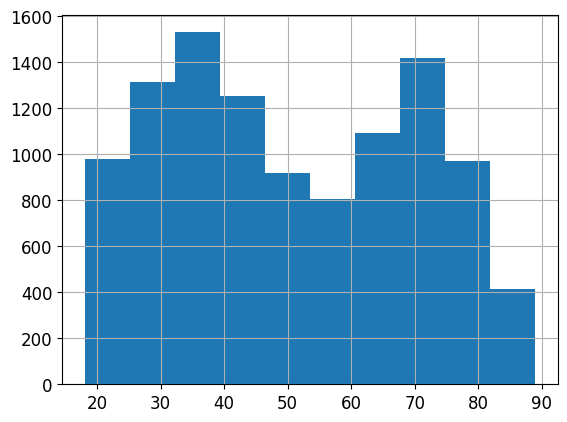

In [ ]:
print(f'Age varies from {df.age.min()} to {df.age.max()}\n')
_=df.age.hist()

In [ ]:
# function used to retun the label from an image
def label_func(file):
    # takes the file's base name w/o the extension
    basename = int(os.path.basename(str(file)).split('.')[0])

    # searches for the label
    label = int(df.age[basename])

    return label

32


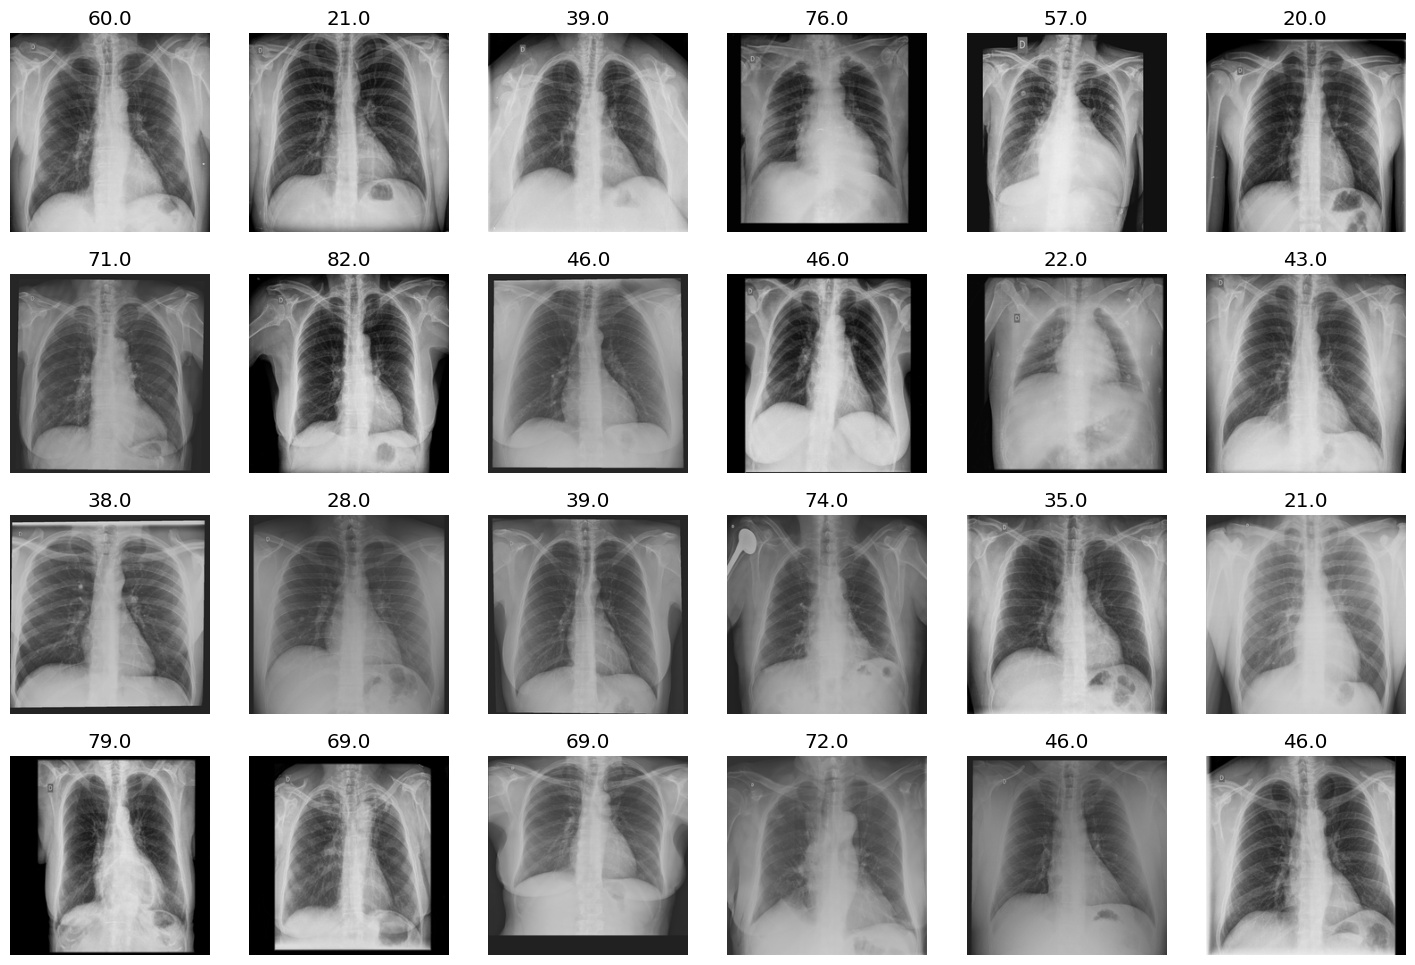

In [ ]:
# defines the image dataloader
dtblk = DataBlock(
    # trabajamos con datos de regresión
    blocks=(ImageBlock, RegressionBlock),
    get_items=get_image_files,
    # 20% de los datos para validación
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    batch_tfms=Resize(224),
    get_y=label_func
    )
dls = dtblk.dataloaders(train_path, bs=32)

print(dls.bs)
# shows some samples
dls.show_batch(max_n=24)

## <font color='blue'>3.1 Entrenamos todo ResNet50 _from scratch_, ajustando la cabecera para este problema.

Primero, vamos a importar las librerías necesarias

In [ ]:
pip install fastai torch torchvision torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 19.6 MB/s eta 0:00:00


In [ ]:
from fastai.vision.all import *
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.models import resnet50

El modelo ResNet50 es un modelo utilizado para problemas de clasificación de imágenes con muchas clases. Sin embargo, nuestro problema es de regresión ya que trata de predecir un número continuo: la edad. Por eso es necesario modificar la cabecera del modelo, la cabecera anterior usaba AvgPooling, Flatten y FullyConnected, pero lo que haremos nosotros será usar solo la FullyConnected (con Flatten antes para poder usarla). Como la última capa convolucional de ResNet50 tiene un output de dimensión 2048x7x7, esta es la cantidad de nueronas de entrada para nuestra FullyConnected en la nueva cabecera.

In [ ]:
# seleccionamos el modelo preentrenado
model = fastai.vision.models.resnet50
# personalizamos la cabecera
custom_head = nn.Sequential(nn.Flatten(), nn.Linear(2048*7*7, 1))

La función de pérdida será Mean Sqaured Error (MSE), porque es la estándar para problemas de regresión: penaliza de manera más fuerte los errores grandes.

Las métricas de evaluación son: MAE (Mean Absolute Error), que mide el error promedio absoluto en años; MSE, que mide qué tan bien generaliza el modelo; y R2 Score, que mide qué procentaje de la variabilidad de los datos es explicado por el modelo (desde - infinito hasta 1).

Para poder usar la cabecera que hemos implementado antes, debemos usar el parámetro _custom_head_ en la función _vision_learner_, que es la función necesaria para definir el Learner con un modelo preentrenado en fastai.

Además, por defecto _vision_learner_ tiene el parámetro pretrained=True, lo que provoca que el modelo comience a entrenarse con los pesos ya preentrenados. Por eso, lo vamos a poner a False, porque queremos entrenarlo desde cero. Con este cambio conseguimos que todas las capas sean entrenables.

In [ ]:
# creamos el Learner de fastai
learn = vision_learner(dls, model, loss_func=MSELossFlat(), metrics=[mae, mse, R2Score()], custom_head=custom_head, pretrained=False)
# mostramos resumen del modelo
learn.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      True      
BatchNorm2d                        

Vamos a usar la función _fit_one_cycle_ porque queremos entrenar todo el modelo, sin dejar ninguna capa congelada.

In [ ]:
# entrenamos el modelo
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mae,mse,r2_score,time
0,359.752380,758.032593,20.818811,758.032593,-1.180878,01:12
1,284.411896,333.755951,14.832058,333.755951,0.039776,01:11
2,196.861801,495.557922,16.500698,495.557922,-0.425732,01:14
3,181.532654,258.798431,11.354828,258.798431,0.255431,01:12
4,126.517899,131.271042,9.161303,131.271042,0.622330,01:14
5,134.897827,149.820053,9.671096,149.820053,0.568964,01:12
6,104.997246,100.075012,7.872929,100.075012,0.712082,01:20
7,73.097054,91.563637,7.566093,91.563637,0.736569,01:13
8,51.835312,84.621117,7.170255,84.621117,0.756543,01:12
9,38.217876,80.950722,7.005206,80.950722,0.767103,01:14


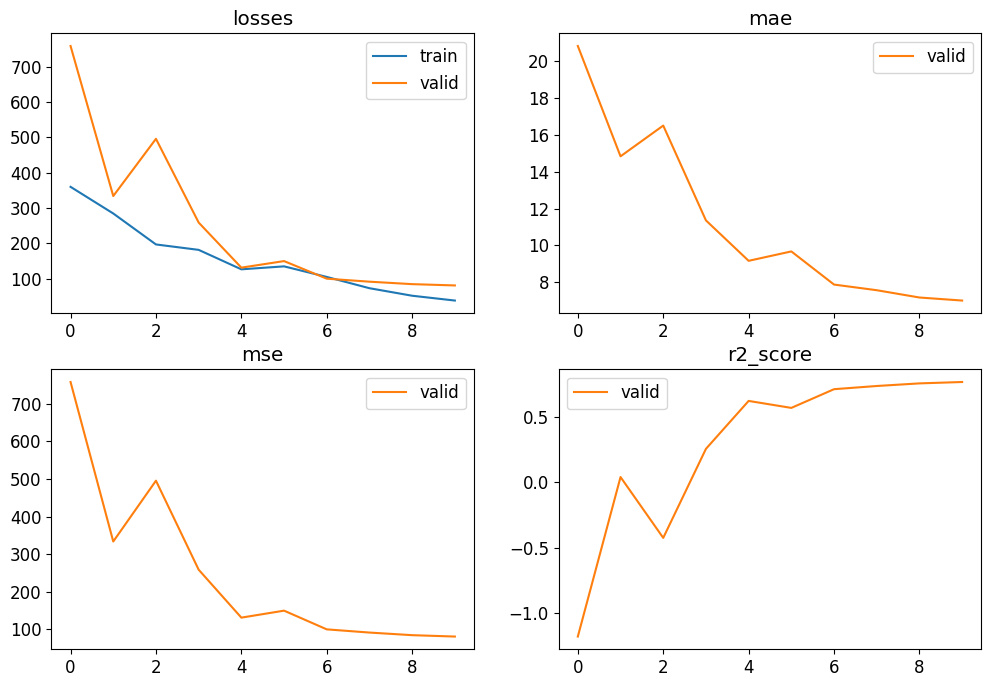

In [ ]:
# graficamos las métricas
learn.recorder.plot_metrics()

In [ ]:
# validamos el modelo en el conjunto de validación
results = learn.validate()
print(f"Val MSE: {results[1]:.4f}, MAE: {results[2]:.4f}, R2: {results[3]:.4f}")

# creamos un dataLoader para el conjunto de test
test_dl = learn.dls.test_dl(test_files,with_labels=True)
# validamos el modelo para test
results_test = learn.validate(dl=test_dl)
print(f"Val MSE: {results_test[1]:.4f}, MAE: {results_test[2]:.4f}, R2: {results_test[3]:.4f}")

Val MSE: 7.0052, MAE: 80.9507, R2: 0.7671


Val MSE: 7.3475, MAE: 91.0097, R2: 0.7639


## Resultados

Al entrenar toda la red desde cero, los resultados son bastante buenos. Con un R2 de 0.7671 en validación obtenemos una buena capacidad predictiva. Sin embargo, vemos que el MSE y MAE en el test son más altos que en validación, lo que puede indicar que hay sobreajuste.



## <font color='blue'>3.2. ResNet50 se usa como extractor de características: Entrenamos solo la cabecera incorporada.



En este apartado cargamos el modelo ResNet50 preentrenado. Las primeras capas del modelo sirven para predecir características generales como bordes, texturas y formas, que son comunes a todos los problemas. Por eso, podemos congelar los pesos de estas capas, ya que nos sirven para nuestro problema. Así, ahorramos tiempo de entrenamiento.

El modelo ResNet será un extractor de carcaterísticas fijo. La última capa la sustituimos por una fully connected con salida de una neurona, que indicará la predicción de la edad, igual que antes.


In [ ]:
# seleccionamos el modelo preentrenado
model = fastai.vision.models.resnet50
# definimos la cabecera personalizada
custom_head = nn.Sequential(nn.Flatten(), nn.Linear(2048*7*7, 1))

Igual que en apartado anterior, usamos la nueva cabecera con el parámetro _custom_head_, pero ahora pondremos pretrained=True, de esta forma todas las capas serán no entrenables excepto la nueva cabecera y las capas batchnorm. Las capas batchnorm queremos que sean entrenables para que el modelo se ajuste mejor a nuestros datos.

En el summary vemos que sólo los pesos de la última capa, que es nuestra cabecera fully connected, son entrenables.

In [ ]:
# creamos el Learner para la regresión
learn = vision_learner(dls, model, loss_func=MSELossFlat(), metrics=[mae, mse, R2Score()], custom_head=custom_head, pretrained=True)
# mostramos el resumen
learn.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

En este caso también usaremos _fit_one_cycle_ porque es la función que entrena solamente los pesos desbloqueados (entrenables), que en nuetsro caso son solamente los de la cabecera (última capa fully connected).

In [ ]:
# entrenamos el modelo
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mae,mse,r2_score,time
0,513.150635,311.755981,14.653287,311.755981,0.103070,01:00
1,170.914520,158.927917,10.144319,158.927917,0.542760,00:57
2,94.206741,144.136108,9.625212,144.136108,0.585317,00:59
3,48.973190,136.964554,9.426429,136.964554,0.605950,01:00
4,36.571598,136.867950,9.358271,136.867950,0.606228,00:57
5,29.235691,128.104233,9.141976,128.104233,0.631441,01:00
6,23.627621,125.692619,8.979123,125.692619,0.638379,00:59
7,16.437069,125.175674,8.970368,125.175674,0.639866,00:58
8,13.854830,125.050911,8.945958,125.050911,0.640225,00:59
9,13.177252,124.338791,8.939458,124.338791,0.642274,00:59


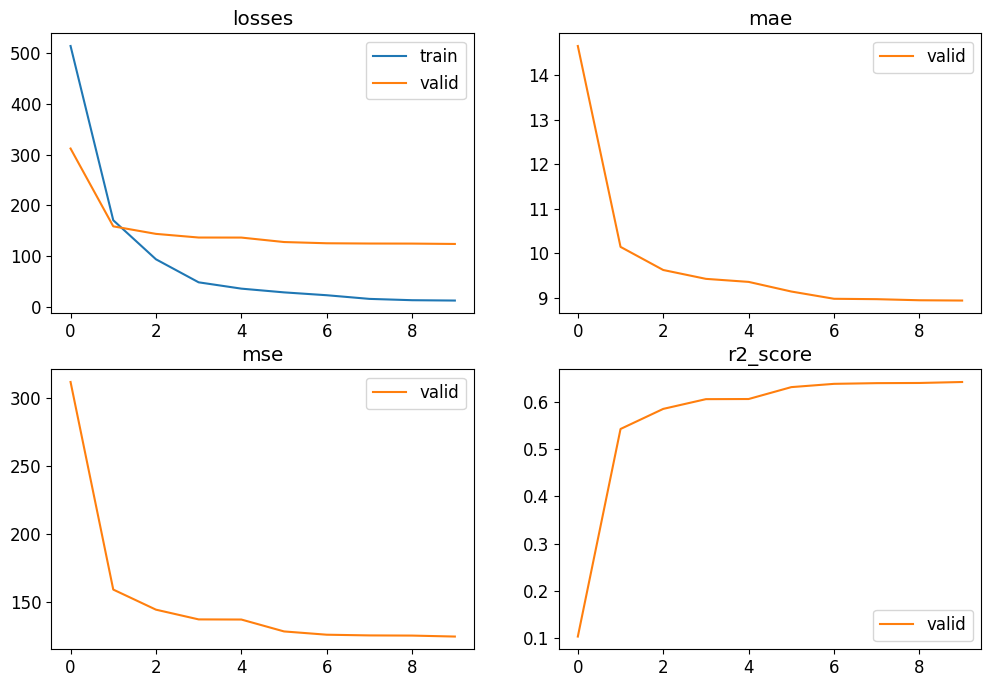

In [ ]:
# graficamos las métricas
learn.recorder.plot_metrics()

In [ ]:
# validamos el modelo en el conjunto de validación
results = learn.validate()
print(f"Val MSE: {results[1]:.4f}, MAE: {results[2]:.4f}, R2: {results[3]:.4f}")

# creamos un DataLoader para el conjunto test
test_dl = learn.dls.test_dl(test_files,with_labels=True)
# validamos el modelo en el conjunto de test
results_test = learn.validate(dl=test_dl)
print(f"Test MSE: {results_test[1]:.4f}, MAE: {results_test[2]:.4f}, R2: {results_test[3]:.4f}")

Val MSE: 8.9395, MAE: 124.3388, R2: 0.6423


Test MSE: 8.6490, MAE: 116.6939, R2: 0.6973


## Resultados

Al usar ResNet50 solo como extractor de características y entrenar solamente la cabecera, vemos que el rendimiento es mucho peor que en el apartado anterior. Esto lo podemos ver en el R2 mucho más bajo en validación y los valores de MSE y MAE más altos tanto en validación como en test. Esto sugiere que el modelo no captura información relevante con solo la cabecera.

## <font color='blue'>3.3. ResNet50 se usa como extractor de características: Entrenamos solo la cabecera incorporada por defecto por fastai.



En este apartado usamos ResNet50 preentrenado, pero en vez de personalizar la cabecera nosotros, usamos la cabecera por defecto que Fastai agrega al modelo. Entrenamos solo esta cabecera, por las mismas razones que en el ejercicio anterior.

Con la función _vision_learner_ se carga ResNet50 preentrenado y se agrega una cabecera por defecto (capas con dimensión adaptada al problema representado en el dataLoader). Las capas adicionales que añade Fastai se pueden ver en el summary: son una avgPooling, una maxPooling y dos FullyConnected, con capas de Dropout y BatchNorm por medio.

Como _vision_learner_ añade esta cabecera por defecto, no hace falta que hagamos uso de _custom_header_, pero sí que usaremos _pretrained=True_, para que sólo sean entrenables los pesos de las capas de la cabecera y los de batchnorm por la misma razón que en el ejercicio anterior.

In [ ]:
# seleccionamos el modelo
model = fastai.vision.models.resnet50

In [ ]:
# creamos el Learner que, por defecto, crea una cabecera personalizada
learn = vision_learner(dls, model, loss_func=MSELossFlat(), metrics=[mae, mse, R2Score()], pretrained=True)
# mostramos el resumen
learn.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

Aquí también usamos _fit_one_cycle_ porque se encargará de que solamente se entrenen los pesos entrenables, que en nuestro caso son los de la cabecera incorporada automáticamente por fastai.

In [ ]:
# entrenamos el modelo
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mae,mse,r2_score,time
0,2752.002441,2710.512207,49.907406,2710.512207,-6.712821,00:55
1,2283.549805,2061.993896,43.785660,2061.993896,-4.867448,00:59
2,793.279602,366.890717,16.367661,366.890717,-0.043995,01:01
3,198.630905,159.436676,10.091390,159.436676,0.546320,00:55
4,154.314316,139.410431,9.500765,139.410431,0.603305,00:58
5,121.690529,125.351143,8.944580,125.351143,0.643311,00:57
6,108.449692,120.018410,8.703451,120.018410,0.658485,00:55
7,97.432549,117.522682,8.585990,117.522682,0.665587,00:57
8,88.982849,114.673546,8.468374,114.673546,0.673694,00:57
9,91.403069,114.198761,8.439760,114.198761,0.675045,00:56


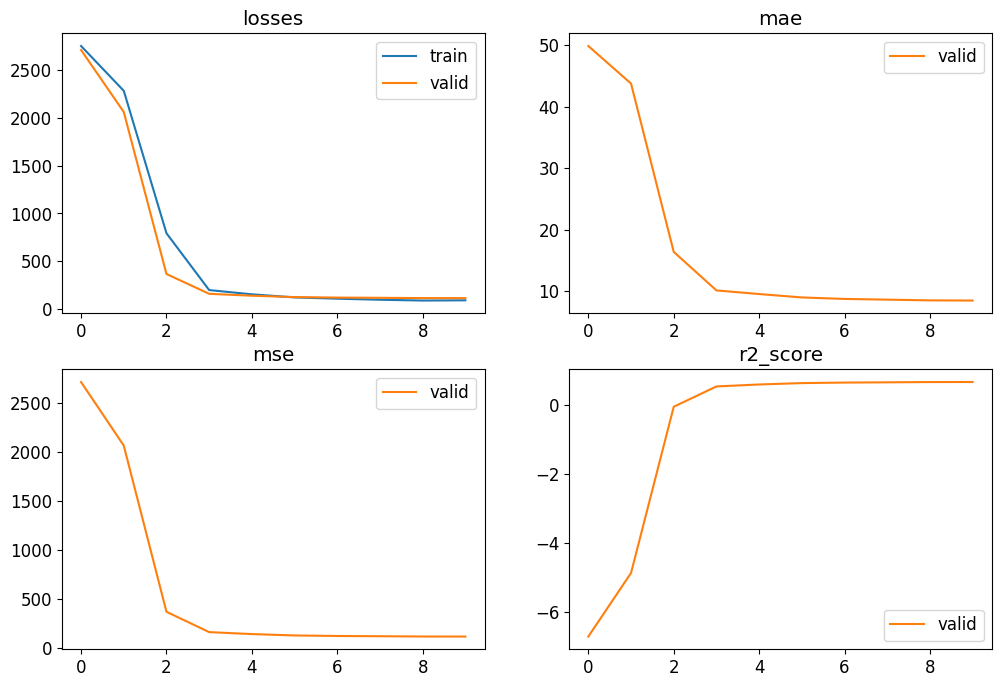

In [ ]:
# graficamos las métricas
learn.recorder.plot_metrics()

In [ ]:
# validamos el modelo en el conjunto de validación
results = learn.validate()
print(f"Val MSE: {results[1]:.4f}, MAE: {results[2]:.4f}, R2: {results[3]:.4f}")

# creamos el DataLoader para el conjunto de test
test_dl = learn.dls.test_dl(test_files,with_labels=True)
# validamos el modelo en el conjunto de test
results_test = learn.validate(dl=test_dl)
print(f"Val MSE: {results_test[1]:.4f}, MAE: {results_test[2]:.4f}, R2: {results_test[3]:.4f}")

Val MSE: 8.4398, MAE: 114.1988, R2: 0.6750


Val MSE: 8.7879, MAE: 121.5909, R2: 0.6846


## Resultados

Ahora los resultados son mejores que en el apartado 3.2, pero siguen siendo peores que en el 3.1. Esto indica que la incorporación de una cabecera predeterminada no mejora suficientemente la capacidad predictiva del modelo.

## <font color='blue'>3.4. Hacemos un ajuste fino (fine-tuning) de toda la red partiendo de los pesos de ImageNet.

En este ejercicio usamos ResNet50 preentrenada, adaptamos la cabecera con la automática de Fastai y, además, realizamos fine-tuning de toda la red. Es decir, entrenamos la cabecera y permitimos que los pesos de las capas convolucionales de ResNet50 sean actualizados.

In [ ]:
# seleccionamos el modelo
model = fastai.vision.models.resnet50
# creamos el Learner con cabecera automática y pesos preentrenados
learn = vision_learner(dls, model, loss_func=MSELossFlat(), metrics=[mae, mse, R2Score()], pretrained=True)
learn.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

Como hemos puesto el parámetro _Pretrained_ a True, tenemos que solo los pesos de la cabecera serán entrenables. Así podemos verlo en el summary de arriba.

Pero, aparte de entrenar la cabecera, también queremos entrenar todas las capas anteriores del modelo, para ajustarlas de mejor manera a nuestro problema. Para conseguirlo, usaremos _fine_tune_ que usa internamente _fit_one_cycle_, pero antes hace dos pasos:
1. Entrena las capas de la cabecera añadidas por fastai durante el número de épocas que le digamos, en nuestro caso 3.

2. Descongela todas las capas y las entrena durante el número de épocas indicado, en nuestro caso 10.

De esta forma, primero conseguimos tener una cabecera con pesos razonables y, posterioremente, mejora aún más el modelo entrenando todas las capas para ajustarlo al problema de regresión que tenemos.

In [ ]:
# entrenamos el modelo
learn.fine_tune(10, freeze_epochs=3)

epoch,train_loss,valid_loss,mae,mse,r2_score,time
0,2701.294189,2716.409668,50.052547,2716.409668,-6.815178,01:04
1,1782.908203,1043.783325,29.874983,1043.783325,-2.002990,01:00
2,306.806702,176.790573,10.585370,176.790573,0.491369,00:59


epoch,train_loss,valid_loss,mae,mse,r2_score,time
0,152.856857,131.038193,9.141753,131.038193,0.623000,01:14
1,121.622742,116.844742,8.619977,116.844742,0.663835,01:14
2,107.899002,107.142494,8.220860,107.142494,0.691748,01:12
3,89.283363,83.003983,7.214536,83.003983,0.761196,01:15
4,75.933517,74.718315,6.955842,74.718315,0.785034,01:12
5,64.849792,70.927773,6.643093,70.927773,0.795939,01:14
6,57.455627,66.312218,6.451958,66.312218,0.809218,01:12
7,50.868404,63.337181,6.325370,63.337181,0.817777,01:20
8,44.050190,62.762852,6.239816,62.762852,0.819430,01:14
9,43.284874,62.395481,6.230943,62.395481,0.820487,01:13


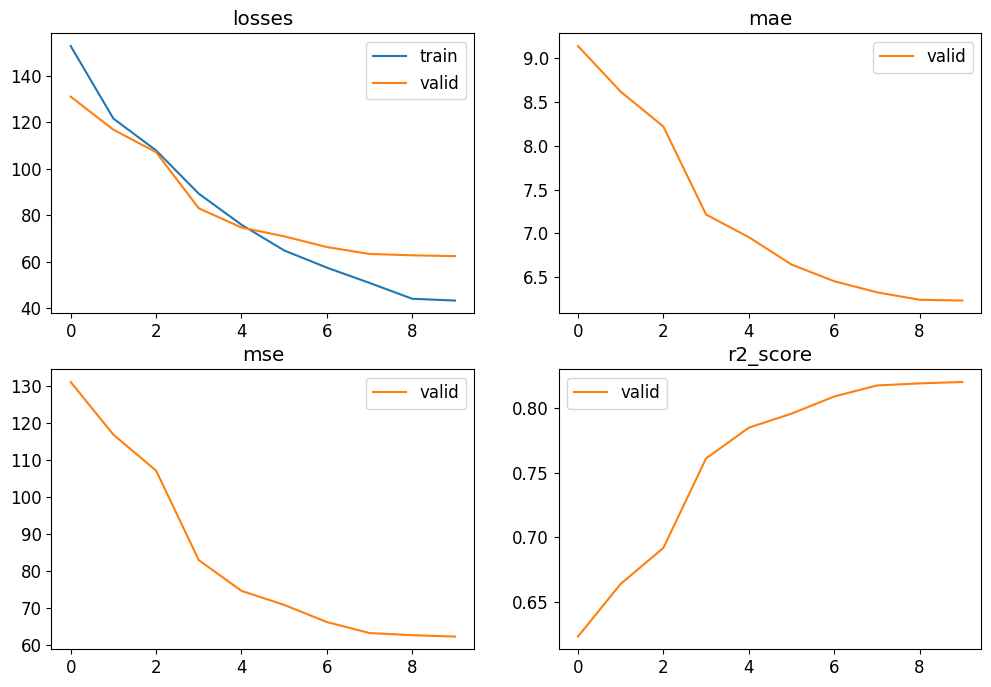

In [ ]:
# graficamos las métricas
learn.recorder.plot_metrics()

In [ ]:
# validamos el modelo en el conjunto de validación
results = learn.validate()
print(f"Val MSE: {results[1]:.4f}, MAE: {results[2]:.4f}, R2: {results[3]:.4f}")

# creamos DataLoader para conjunto de test
test_dl = learn.dls.test_dl(test_files,with_labels=True)
# validamos el modelo en el conjunto de test
results_test = learn.validate(dl=test_dl)
print(f"Val MSE: {results_test[1]:.4f}, MAE: {results_test[2]:.4f}, R2: {results_test[3]:.4f}")

Val MSE: 6.2309, MAE: 62.3955, R2: 0.8205


Val MSE: 5.9141, MAE: 56.0343, R2: 0.8547


## Resultados

Este apartado ha sido el que ha dado los mejores resultados. El R2 en validación y en test son mucho más altos, lo que indica una mejora significativa en la capacidad de predicción y generalización (en test). Además, los valores de MSE y MAE son los más bajos de todos los apartados, lo que coincide con que el fine tuning es la estrategia más efectiva cuando tenemos un modelo preentrenado.

## <font color='blue'>Conclusiones. ¿Qué conclusiones se pueden extraer en base a toda la experimentación anterior? En caso de que nos enfrentemos a un nuevo problema, ¿qué opción, u opciones, de entre las anteriores, parece a priori la más razonable? ¿Por qué?

Como ya hemos comentado, el fine tuning ha sido la opción con mejores resultados de todo el experimento. En este apartado partíamos de un modelo preentrenado en ImageNet y hemos ajustado sus pesos, logrando una mejora significativa en el rendimeinto. Esto es lo esperable, ya que el modelo preentrenado ya tiene conocimientos relevantes sobre características visuales generales y, al adaptarlo esecíficamente al problema, se aprovechan esas características para mejorar la capacidad predictiva.

Teníamos otras opciones como entrenar la red completa desde cero (apartado 3.1) que también mostraba buenos resultados, indicando que ResNet50 es bastante robusto para nuestro ejercicio. La diferencia es que el fine tuning optimiza mucho más el resultado porque utiliza un modelo preentrenado.

Las otras opciones usaban ResNet50 como extractor de características, pero no se optimizaban lo suficiente las características verdaderamente relevantes para las radiografías. Por eso estos apartados mostraban los peores resultados.

**En un nuevo problema**

En un nuevo problema, la opción más razonable parece fine tuning, ya que aprovecha un modelo preentrenado para adaptarlo al nuevo problema.

Aun así, si el modelo preentrenado no parece adecuado para el nuevo problema y se tiene una cantidad de datos suficiente, podríamos entrenar la red desde cero.